<p style="color: navy; font-family: verdana; font-size: large"> EVICTION PREDICTIONS IN BROOKLYN - A SciKitLearn Linear Regression Tutorial

Background: The economic shut-downs caused by COVID-19 have caused new high rates of unemployment, varying by sector. This new unemployment is already and will continue to cause major losses in income to many households leading to other issues such as inability to pay rent. There will likely be many households who end up facing eviction as an indirect consequence of COVID-19.


Preparing the Data

With American Community Survey data, Princeton's Eviction Lab data, a NYC census-tract shapefile, and FiveThirtyEight's unemployment by sector data, we can build a model to predict evictions and then apply it to a scenario of higher unemployment rates to predict evictions that will be indirectly due to COVID-19.
Data can be found here: 
https://evictionlab.org/get-the-data/ (eviction-rate, rent-burden, poverty-rate)
https://data.census.gov/cedsci/ (MedianRent2016, MedianRent2012, TotalEmployees, FoodServicePct, FinancialPct, EducationPct, SocialServPct, ConstructionPct, and Shipping_Manuf)
https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku
https://fivethirtyeight.com/features/the-industries-hit-hardest-by-the-unemployment-crisis/

The first step is to gather the data of the value you are trying to predict (eviction rate), and the values that can be used to predict it. The values I chose as possible predictors of eviction rate are unemployment rate, change in rent 2012-2016, poverty rate, and rent burden (paying more than 30% income on rent).

To use the census data, I recommend searching by topic (ex- 'gross median rent' or 'unemployment'). Once you find a topic of interest, select it. This will bring you to the next screen where you can select a data product. Choose your desired year as the 5-year estimate option. Now, choose customize table and choose geographies. I used census-tracts, but you can use other geographies. It will just have to match the geography you choose for your Eviction Lab data. When you are satisfied with your data selection, choose download.

Now, your census data will have some column for its geography that will match with a column from the Eviction Lab data. Merge these two tables based on that common column. Now you have a file of all of your necessary data. The last step for preparing the data is to associate it with the geographies in your shapefile. Again, there should be a column in your data file that matches a column in the shapefile. Use geopandas to join the data to the shapefile (which will be demonstrated in this notebook).

Finally, you are in a position to do data analysis and easily link the resulting statistics/models to a geography! 

For this tutorial, combined datasets are ready for use. I removed all census tracts with fewer than 30 residents and all census tracts/zipcodes that had a missing value in any of the independent or dependent variables. You will need bkTracts2.shp, tracts.csv, bkZips.shp, and gtech733final.csv

A great tutorial that helped me learn these skills can be found here: https://github.com/holjose/GTECH733Final/blob/master/county_elections.ipynb</p>



<p style="color: navy; font-family: verdana; font-size: large">Step One - Import necessary packages and libraries</p>

In [336]:
%matplotlib inline

# Import libraries used below
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix

# Set up global display defaults 
pd.options.display.max_rows = 10 
pd. options.display.max_columns = 500

<p style="color: navy; font-family: verdana; font-size: large">Step Two - Read in the data of the shapefilefile. Set the index to the geometry that matches in your data file.</p>

In [337]:
#Shapefile of census tracts
tracts = gpd.read_file('./bkTracts2.shp')
tracts['ct2010']=tracts['ct2010'].astype(int)
tracts = tracts.set_index('ct2010')
tracts.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
ct2010,,,,,,,,,,,
7800,3,3007800,Brooklyn,E,78,BK32,Sunset Park West,4012,1.509792e+06,4986.671595,"POLYGON ((-74.00915 40.64623, -74.00974 40.645..."
8000,3,3008000,Brooklyn,E,80,BK32,Sunset Park West,4012,1.506326e+06,4989.723103,"POLYGON ((-74.00682 40.64846, -74.00741 40.647..."
501,3,3000501,Brooklyn,I,5.01,BK09,Brooklyn Heights-Cobble Hill,4004,9.015070e+05,4828.170042,"POLYGON ((-73.99302 40.69746, -73.99379 40.695..."
4100,3,3004100,Brooklyn,I,41,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,1.744094e+06,5283.856660,"POLYGON ((-73.98182 40.68733, -73.98223 40.686..."
5800,3,3005800,Brooklyn,E,58,BK31,Bay Ridge,4013,2.080303e+06,6098.167800,"POLYGON ((-74.02956 40.61983, -74.02821 40.619..."


<p style="color: navy; font-family: verdana; font-size: large"> Step Three - Read in your data file. Set the index to match your SHapefile.</p>

In [338]:
#Data by census tract
bkData = pd.read_csv('./tracts.csv')

#Make sure data is of type float and that NaNs are removed
bkData.dropna(inplace=True)
indices_to_keep = ~bkData.isin([np.nan, np.inf, -np.inf]).any(1)
bkData=bkData[indices_to_keep].astype(np.float64)
bkData['ct2010']=bkData['ct2010'].astype(int)
bkData = bkData.set_index('ct2010')
bkData.head()

,MedianRent2016,MedianRent2012,Change20162012,UnempRate2016,eviction-rate,eviction-filing-rate,rent-burden,poverty-rate,TotalEMployees,FoodServicePct,FinancialPct,EducationPct,SocialServPct,ConstructionPct,Shipping_Manuf
ct2010,,,,,,,,,,,,,,,
501,1894.0,1886.0,8.0,5.9,0.0,1.48,24.8,4.33,2435.0,0.027105,0.118686,0.068994,0.012731,0.000000,0.008624
700,2115.0,1871.0,244.0,3.2,0.0,2.09,23.8,1.18,2329.0,0.003006,0.155002,0.054100,0.006870,0.010734,0.024045
1300,2204.0,1707.0,497.0,2.8,0.0,0.79,27.4,1.53,994.0,0.006036,0.144869,0.117706,0.032193,0.019115,0.006036
3000,1423.0,1342.0,81.0,7.3,0.0,1.53,23.8,9.78,872.0,0.000000,0.069954,0.142202,0.013761,0.044725,0.071101
3700,2646.0,1862.0,784.0,3.9,0.0,2.52,27.1,4.32,1221.0,0.033579,0.109746,0.014742,0.007371,0.000000,0.000000


<p style="color: navy; font-family: verdana; font-size: large"> Step 4 - Join the data with the shapefile based on a common column. It is possible that a common column would have different names in the two files despite having the same values. You can index them based on their common value and change the names of the columns to match to successfully join the two data frames.</p>

In [339]:
bkGeoData = tracts.join(bkData, on='ct2010')
bkGeoData.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,MedianRent2016,MedianRent2012,Change20162012,UnempRate2016,eviction-rate,eviction-filing-rate,rent-burden,poverty-rate,TotalEMployees,FoodServicePct,FinancialPct,EducationPct,SocialServPct,ConstructionPct,Shipping_Manuf
ct2010,,,,,,,,,,,,,,,,,,,,,,,,,,
7800,3,3007800,Brooklyn,E,78,BK32,Sunset Park West,4012,1.509792e+06,4986.671595,"POLYGON ((-74.00915 40.64623, -74.00974 40.645...",1358.0,1139.0,219.0,8.9,0.88,3.35,34.2,23.61,2715.0,0.098343,0.025046,0.033886,0.031676,0.078085,0.184530
8000,3,3008000,Brooklyn,E,80,BK32,Sunset Park West,4012,1.506326e+06,4989.723103,"POLYGON ((-74.00682 40.64846, -74.00741 40.647...",1559.0,1098.0,461.0,7.5,0.86,1.93,35.6,10.60,1963.0,0.074376,0.036679,0.050942,0.032603,0.102394,0.131941
501,3,3000501,Brooklyn,I,5.01,BK09,Brooklyn Heights-Cobble Hill,4004,9.015070e+05,4828.170042,"POLYGON ((-73.99302 40.69746, -73.99379 40.695...",1894.0,1886.0,8.0,5.9,0.00,1.48,24.8,4.33,2435.0,0.027105,0.118686,0.068994,0.012731,0.000000,0.008624
4100,3,3004100,Brooklyn,I,41,BK38,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,4004,1.744094e+06,5283.856660,"POLYGON ((-73.98182 40.68733, -73.98223 40.686...",2044.0,1825.0,219.0,2.9,0.53,1.68,27.6,0.00,2097.0,0.017644,0.103004,0.074392,0.015737,0.003815,0.024797
5800,3,3005800,Brooklyn,E,58,BK31,Bay Ridge,4013,2.080303e+06,6098.167800,"POLYGON ((-74.02956 40.61983, -74.02821 40.619...",1311.0,1207.0,104.0,8.5,0.23,2.43,33.4,21.09,1511.0,0.063534,0.090668,0.117141,0.000000,0.051621,0.088021


<p style="color: navy; font-family: verdana; font-size: large">View the data of your variable that will be modeled on a map. In this case it is eviction rate.</p>

C:\Users\Holly\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


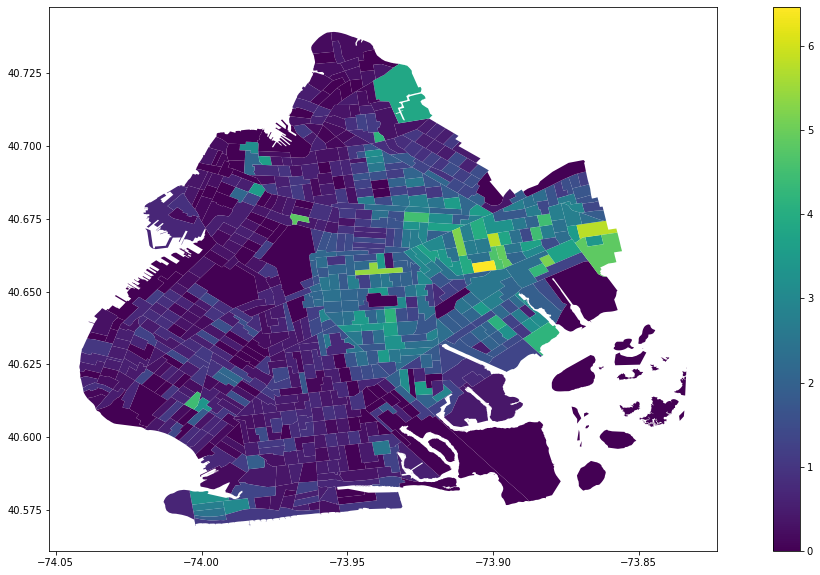

In [340]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1, 1)
bkGeoData.plot(column='eviction-rate', ax=ax, legend=True)

<p style="color: navy; font-family: verdana; font-size: large"> Now that the data is loaded in, we have to begin building the model. The predictors of eviction rate mentioned above -unemployment rate, rent burden, poverty rate, and change in rent 2012-2016 - are predictors I chose and for which I found data. While it sounds possible that these characteristics of a census tract would be adequate to predict eviction rates in that census tract, the only way to know is through testing. Scatter plots assist in visualizing which variables possess a natural linear relationship with the dependent varaible, eviction rate.</p>

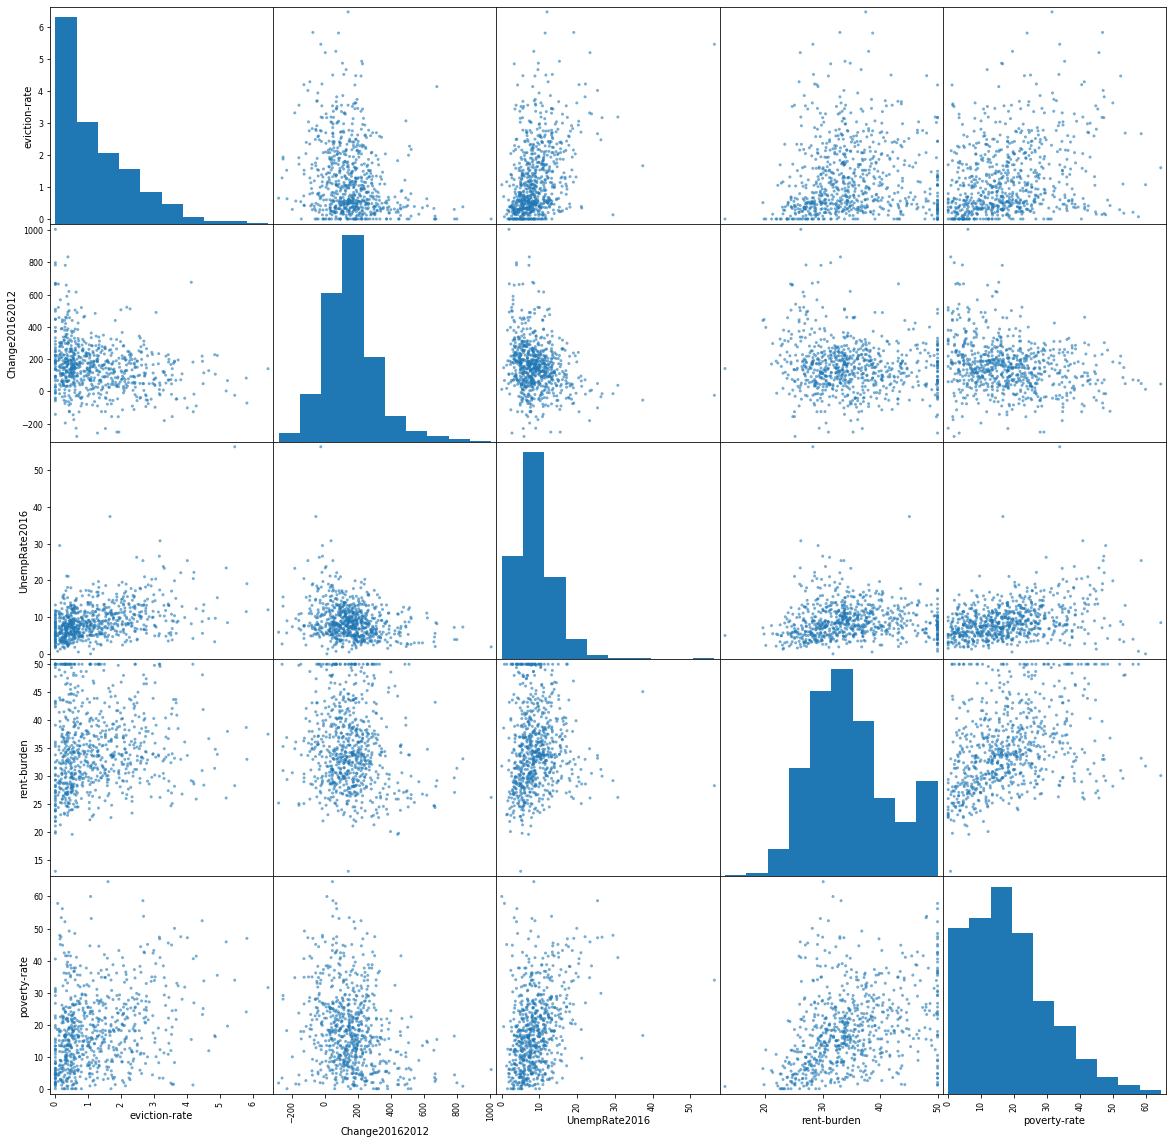

In [341]:
bkScatter = bkGeoData[["eviction-rate", "Change20162012", "UnempRate2016", 
                        "rent-burden", "poverty-rate"]]
plt.rcParams['figure.figsize'] = [20, 20]
scatter_matrix(bkScatter, alpha=.6)
plt.show()

<p style="color: navy; font-family: verdana; font-size: large"> In these scatter plots and histograms, we are interested to see the relationship between eviction-rate and the other variables. The top row is our row of interest as eviction rate is on the y-axis in these plots. Unfortunately, none of the variables produce a strong linear relationship. None of the variables seem to have a very strong relationship of any type with eviction rate. Unemployment rate, rent-burden, and poverty-rate at least have some relationship while the change in rent 2012-2016 seems to have no relationship at all. At this point, I could search for new variables, or give these linear regressions a test to see what happens. I will try it. </p>

In [342]:
#setting up for linear regression, making sure the series are float.
bkGeoData = bkGeoData.dropna(axis=0, how='any')
bkGeoData['Change20162012']=bkGeoData['Change20162012'].astype(float)
bkGeoData['UnempRate2016']=bkGeoData['UnempRate2016'].astype(float)
bkGeoData['rent-burden']=bkGeoData['rent-burden'].astype(float)
bkGeoData['poverty-rate']=bkGeoData['poverty-rate'].astype(float)
bkGeoData['eviction-rate']=bkGeoData['eviction-rate'].astype(float)

#set the independent and dependent variables
X = bkGeoData[["Change20162012", "UnempRate2016", "rent-burden", "poverty-rate"]]
y = bkGeoData["eviction-rate"]

<p style="color: navy; font-family: verdana; font-size: large">This next line splits the data into training and testing data. From the 735 census tracts, 80% will be chosen randomly to build the model. Then 40% of the data will be tested in the newly built model and the results of those 20% (predicted eviction rate) will be compared to the actual eviction rates of those census tracts.</p>

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

<p style="color: navy; font-family: verdana; font-size: large"> Get the model equation by printing the coefficients with their matching independe.t variable and adding the intercept value. THen plot the differences between the predicted values from them model and the test values from the data.</p>

Result equation: eviction-rate = -0.001000774304359844(Change in rent 2012-2016) + 0.07126496263949106(Unemployment rate 2016) + 0.0034733733634955523(Percentage rent-burdened) + 0.007691788205576907(Poverty rate) + 0.49108565540206406


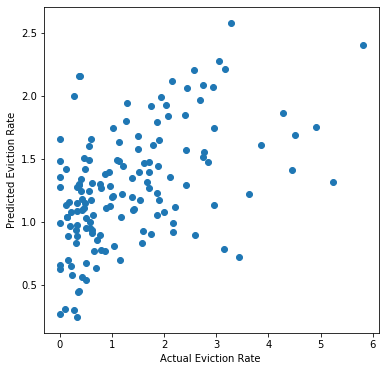

In [344]:
#To get the model equation
print("Result equation: eviction-rate = "+ str(lm.coef_[0])+"(Change in rent 2012-2016) + "+str(lm.coef_[1])+"(Unemployment rate 2016) + "+str(lm.coef_[2])+"(Percentage rent-burdened) + "+str(lm.coef_[3])+"(Poverty rate) + "+str(lm.intercept_))

#Plot the predictions data set
predictions = lm.predict(X_test)
plt.figure(figsize=(6, 6))
plt.scatter(y_test,predictions)
plt.ylabel('Predicted Eviction Rate')
plt.xlabel('Actual Eviction Rate ')
plt.show()

<p style="color: navy; font-family: verdana; font-size: large">  We can also view these predicted-actual values on a map to see where the model is off by the most. Chose a color scheme where the middle values are distinct from the extreme high and low values.</p>

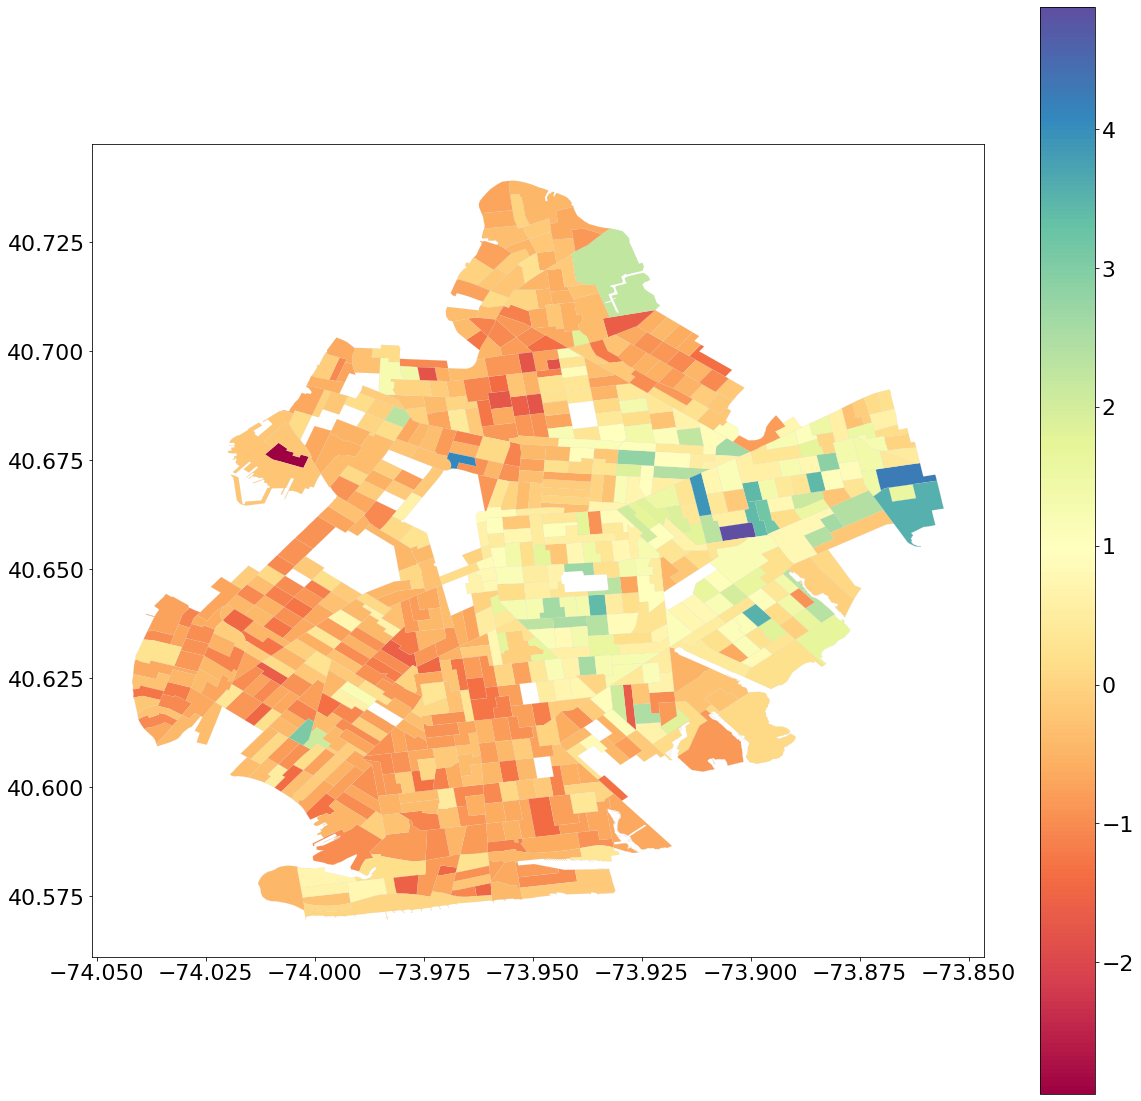

In [345]:
plt.rcParams.update({'font.size': 22})
bkGeoData["predicted"] = lm.predict(X)
bkGeoData["residuals"] = bkGeoData["eviction-rate"] - bkGeoData["predicted"] 
bkGeoData.plot(column="residuals", cmap="Spectral", linewidth=0.1, edgecolor="0.8", legend=True)

<p style="color: navy; font-family: verdana; font-size: large"> An ideal model would be the line y=x in the first figure and a map of '0' values in the second figure. This model definitely has a linear relationship, but it is not too close to the ideal. Get the r-squared value to assess the model a little bit more. </p>

In [346]:
from sklearn.metrics import r2_score
print("R-squared = " + str(r2_score(bkGeoData["eviction-rate"], bkGeoData["predicted"])))

R-squared = 0.19054241302362473


<p style="color: navy; font-family: verdana; font-size: large"> An R-squared value of .19 is very low for a model. So, these variables do not seem to be great predictors of eviction rate by census tract. From the scatter plots, it was clear the the change in rent 2012-2016 had almost no relationship with eviction rate. I will try removing that variable and re-running the model to see if it returns a stronger model. </p>

Result equation: eviction-rate = 0.009765110697982776(Poverty Rate) + 0.0776339347825512(Unemployment rate 2016) + 0.004642892287445917(Percentage rent-burdened) + 0.1973331915975609


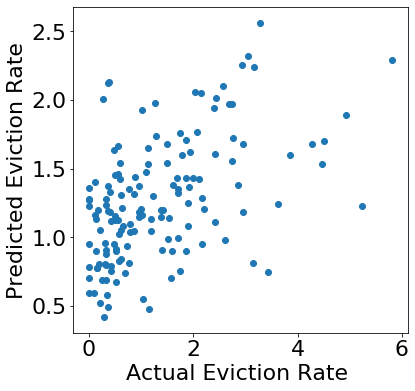

In [347]:
X = bkGeoData[["poverty-rate", "UnempRate2016",'rent-burden']]
y = bkGeoData["eviction-rate"]
X_train, X_test2, y_train, y_test2 = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

#To get the model equation
print("Result equation: eviction-rate = "+ str(lm.coef_[0])+"(Poverty Rate) + "+str(lm.coef_[1])+"(Unemployment rate 2016) + "+str(lm.coef_[2])+"(Percentage rent-burdened) + "+str(lm.intercept_))

#Plot the predictions data set
predictions2 = lm.predict(X_test2)
plt.figure(figsize=(6, 6))
plt.scatter(y_test2,predictions2)
plt.ylabel('Predicted Eviction Rate')
plt.xlabel('Actual Eviction Rate ')
plt.show()



R-squared = 0.17635703768159172


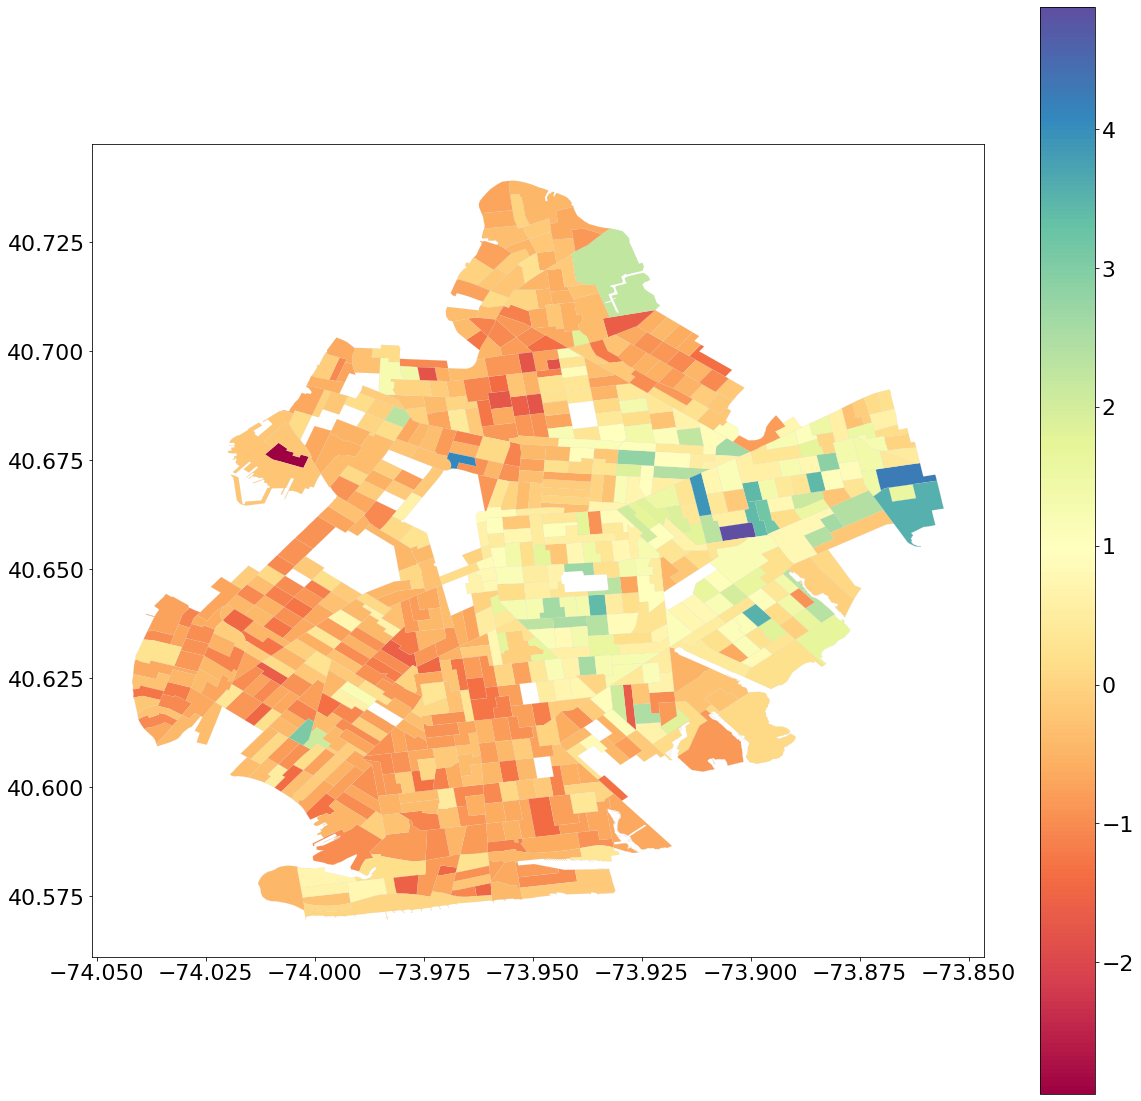

In [348]:
plt.rcParams.update({'font.size': 22})
bkGeoData["predicted2"] = lm.predict(X)
bkGeoData["residuals2"] = bkGeoData["eviction-rate"] - bkGeoData["predicted2"] 
from sklearn.metrics import r2_score
print("R-squared = " + str(r2_score(bkGeoData["eviction-rate"], bkGeoData["predicted2"])))
bkGeoData.plot(column="residuals", cmap="Spectral", linewidth=0.1, edgecolor="0.8", legend=True)

<p style="color: navy; font-family: verdana; font-size: large"> Interestingly, the model without the rent change data actually predicts slightly worse than the first model. The second model's R-squared value is only .176. I will try once more with just unemployment rate as an independent variable. This is because unemployment rate is necessary for the next part of the project.</p>

Result equation: eviction-rate = [[0.08544743]]UnemploymentRate + [0.469846]


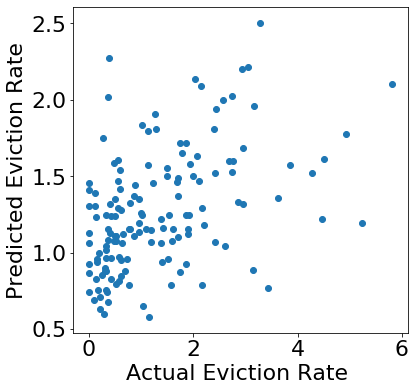

r-square: 0.15795016004640472


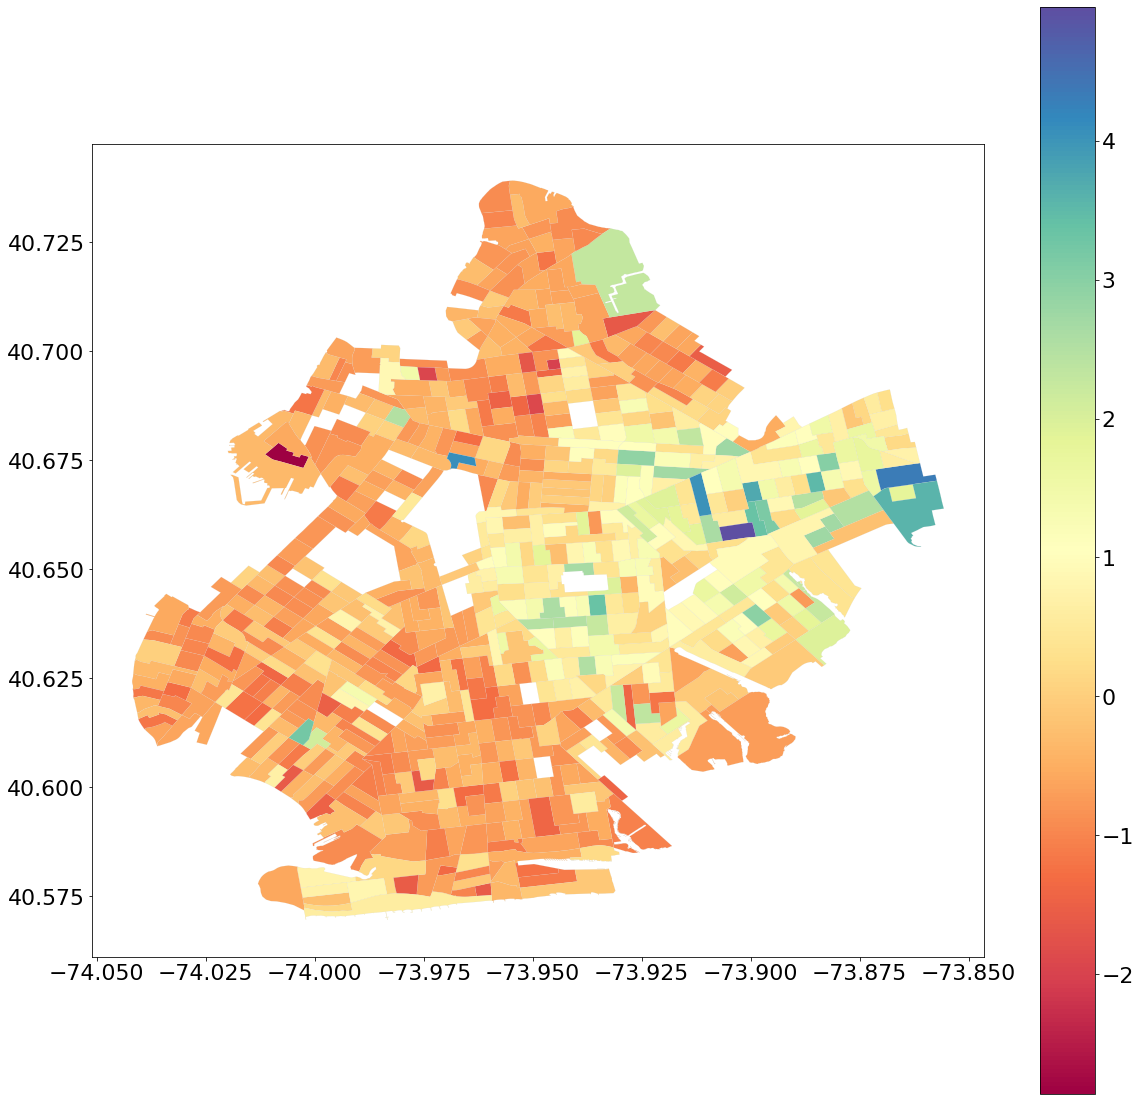

In [349]:
#Just Unemployment Rate
X = bkGeoData["UnempRate2016"].values.reshape(-1,1)
y = bkGeoData["eviction-rate"].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
#To retrieve the intercept:
print("Result equation: eviction-rate = "+ str(lm.coef_)+"UnemploymentRate + "+str(lm.intercept_))
predictions = lm.predict(X_test)
plt.figure(figsize=(6, 6))
plt.scatter(y_test,predictions)
plt.ylabel('Predicted Eviction Rate')
plt.xlabel('Actual Eviction Rate ')
plt.show()
plt.rcParams.update({'font.size': 22})
bkGeoData["predicted"] = lm.predict(X)
bkGeoData["residuals"] = bkGeoData["eviction-rate"] - bkGeoData["predicted"] 
bkGeoData.plot(column="residuals", cmap="Spectral", linewidth=0.1, edgecolor="0.8", legend=True)
from sklearn.metrics import r2_score
print('r-square: '+ str(r2_score(bkGeoData["eviction-rate"], bkGeoData["predicted"])))

<p style="color: navy; font-family: verdana; font-size: large"> Unfortunately, the model with just unemployment rate performed the worst of all with an R-Squared value of .158. Seems like it is time to reassess the model. One option would be to try a different pattern such as taking the log of certain variables.</p>

Result equation: eviction-rate = 0.12059478478484091(Poverty Rate) + 0.07852975600564385(Unemployment rate 2016) + 0.1403367544204029(Percentage rent-burdened) + -0.14159156809872497


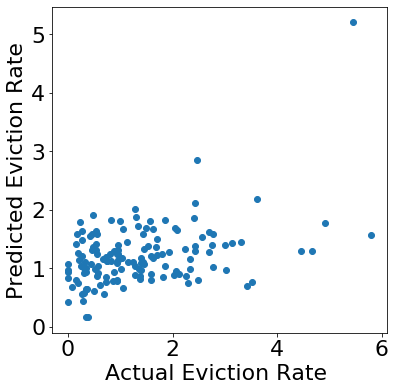

r-square: 0.18474883044998347


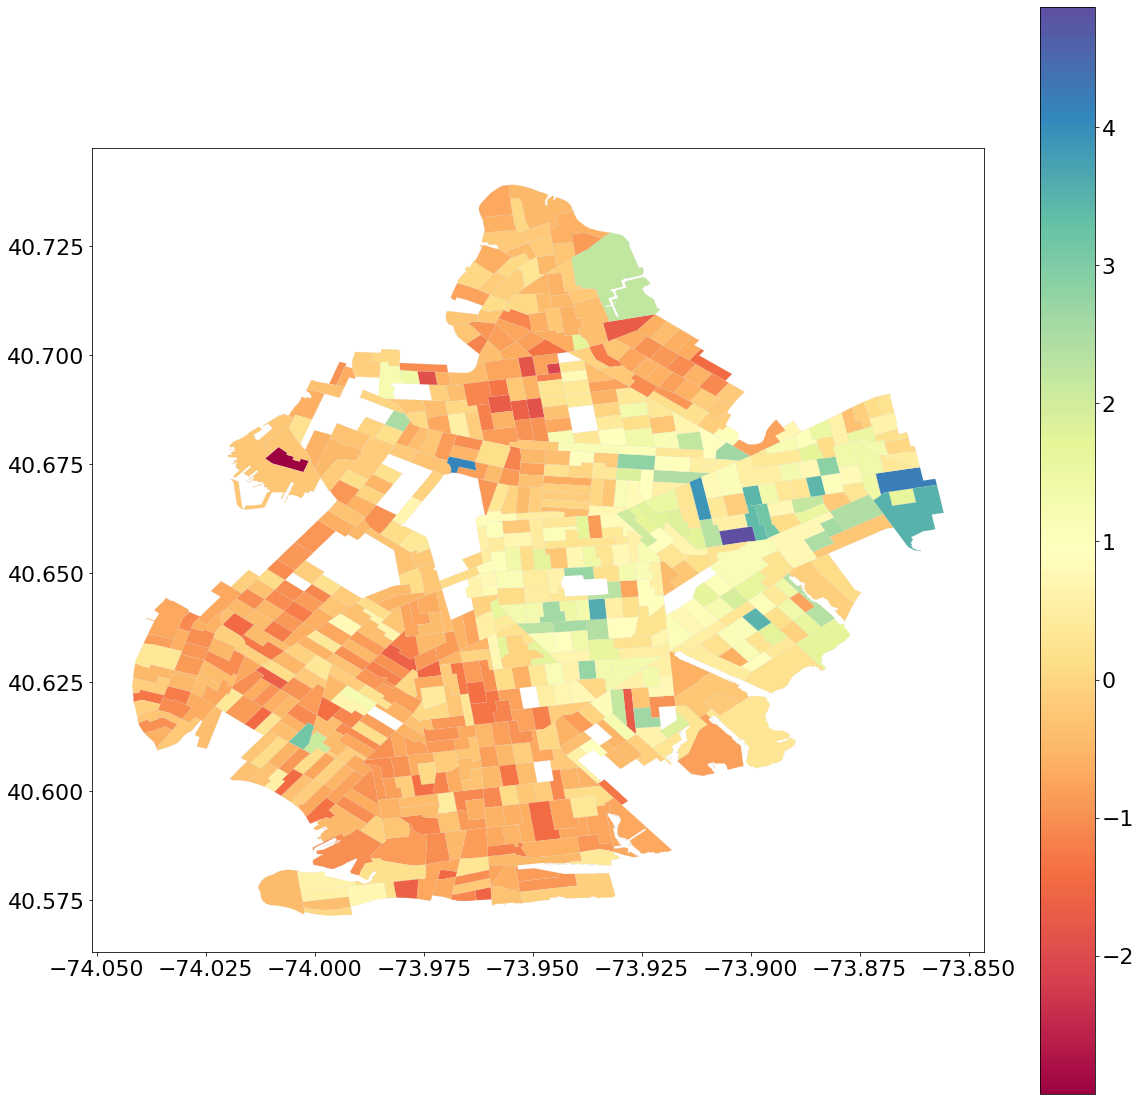

In [350]:
bkGeoData["poverty-rateLog"]=np.log(bkGeoData["poverty-rate"])
bkGeoData["rent-burdenLog"]=np.log(bkGeoData["rent-burden"])
bkGeoData["unempLog"]=np.log(bkGeoData["UnempRate2016"])
bkGeoData=bkGeoData.replace([np.inf,-np.inf],np.nan)
bkGeoData=bkGeoData.dropna(axis=0, how='any')



X = bkGeoData[["poverty-rateLog", "UnempRate2016",'rent-burdenLog','Change20162012']]
y = bkGeoData["eviction-rate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

#To get the model equation
print("Result equation: eviction-rate = "+ str(lm.coef_[0])+"(Poverty Rate) + "+str(lm.coef_[1])+"(Unemployment rate 2016) + "+str(lm.coef_[2])+"(Percentage rent-burdened) + "+str(lm.intercept_))


predictions = lm.predict(X_test)
plt.figure(figsize=(6, 6))
plt.scatter(y_test,predictions)
plt.ylabel('Predicted Eviction Rate')
plt.xlabel('Actual Eviction Rate ')
plt.show()
plt.rcParams.update({'font.size': 22})
bkGeoData["predicted"] = lm.predict(X)
bkGeoData["residuals"] = bkGeoData["eviction-rate"] - bkGeoData["predicted"] 
bkGeoData.plot(column="residuals", cmap="Spectral", linewidth=0.1, edgecolor="0.8", legend=True)
from sklearn.metrics import r2_score
print('r-square: '+ str(r2_score(bkGeoData["eviction-rate"], bkGeoData["predicted"])))


<p style="color: navy; font-family: verdana; font-size: large"> I played around with several combinations of log and untransformed variables. The log model improved the results slightly, but the highest r-squared model was still the first one with all 4 un-transformed variables. Seems like this data is not great for a linear model. I made a much smaller data set by zip code. I am curious if a larger geography would have more of a pattern. Originally, I did not use this other data set because there are only 36 zipcodes, and that is a fairly small size. A general rule of thumb is to have at least 30 samples and at least 10 samples for each independent variable included in the model. Thus, I will only be able to include 3 independent variables at a maximum. Note: The data in the zipcodes set is from the American Community Survey 2018 for census data, NYC Open Data for evictions data (2017-Present), and Zillow.com for market rent. (The rent estimates are different than the census data used in the census tract modeling. This is okay though because the variable included is the change in rent, not net rent). THe next few cells repeat the steps from above but with new zipcode data. (Note: the Change2012_2019 and CHange2016_2019 are changes in median rent.)</p>

In [351]:
#loading in zipcodes shapefile
zips = gpd.read_file('./bkZips.shp')
zips['ZIPCODE']=zips['ZIPCODE'].astype(int)
zips = zips.set_index('ZIPCODE')
zips.head()

,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
ZIPCODE,,,,,,,,,,,,
11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."
11226,0,Brooklyn,106132.0,3.940860e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((994821.473 177865.718, 994891.817 17..."


In [352]:
bkDataZips = pd.read_csv('./gtech733final.csv')
bkDataZips = bkDataZips.dropna(axis=0, how='all')
bkDataZips = bkDataZips.set_index('ZIPCODE')
bkDataZips.head()

,UnemploymentRate,EvictionsSince2017,EvictionRate,RentBurden,MedianRent2012,MedianRent2016,MedianRent2019,Change2012_2019,Change2016_2019,PctWith1.5OrMorePerRoom,WorkingPop,NumInConst,% In Construction,NumInManu,% In Manufacturing,%InTradeTransit,NumInTradeTransit,NumInIT,% In IT,NumInFinance,% In Finance,NumInSW,% In Social Work,NumInArt,% In Arts,ZIP
ZIPCODE,,,,,,,,,,,,,,,,,,,,,,,,,,
11201,0.06,178,0.010077,27.9,2395,2987,2779,384,-208,3.1,30337.8084,488.0,0.02,1030.0,0.03,0.08,2460.0,3420.0,0.11,4660.0,0.15,5840.0,0.19,2210.0,0.07,11201
11203,0.12,930,0.056422,51.5,1600,2073,2177,577,104,1.4,51915.5712,2660.0,0.05,1940.0,0.04,0.16,8200.0,1820.0,0.04,5320.0,0.10,18700.0,0.36,2230.0,0.04,11203
11204,0.06,204,0.013735,55.7,1641,2176,2093,452,-83,4.9,37994.1120,2180.0,0.06,4130.0,0.11,0.18,6940.0,1060.0,0.03,4530.0,0.12,7850.0,0.21,3010.0,0.08,11204
11205,0.20,220,0.017786,41.3,2149,2843,2697,548,-146,4.3,20222.6094,570.0,0.03,1230.0,0.06,0.15,2940.0,1440.0,0.07,1650.0,0.08,4930.0,0.24,1290.0,0.06,11205
11206,0.19,406,0.014621,41.4,1892,2679,2530,638,-149,4.9,32893.7480,1680.0,0.05,4350.0,0.13,0.17,5690.0,842.0,0.03,2600.0,0.08,6510.0,0.20,3190.0,0.10,11206


In [353]:
bkGeoDataZips = zips.join(bkDataZips, on='ZIPCODE')
bkGeoDataZips.head()

,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,UnemploymentRate,EvictionsSince2017,EvictionRate,RentBurden,MedianRent2012,MedianRent2016,MedianRent2019,Change2012_2019,Change2016_2019,PctWith1.5OrMorePerRoom,WorkingPop,NumInConst,% In Construction,NumInManu,% In Manufacturing,%InTradeTransit,NumInTradeTransit,NumInIT,% In IT,NumInFinance,% In Finance,NumInSW,% In Social Work,NumInArt,% In Arts,ZIP
ZIPCODE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",0.16,850,0.040239,49.8,1703,2324,2323,620,-1,2.7,35481.5680,1590.0,0.04,1530.0,0.04,0.16,5790.0,1330.0,0.04,3420.0,0.10,11700.0,0.33,2030.0,0.06,11213
11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",0.20,1291,0.048163,55.5,1580,2122,2145,565,23,2.3,43457.6583,2130.0,0.05,2320.0,0.05,0.16,6970.0,1010.0,0.02,3740.0,0.09,15100.0,0.35,2710.0,0.06,11212
11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",0.13,600,0.029516,45.1,1646,2286,2260,614,-26,2.3,38812.8564,1680.0,0.04,1950.0,0.05,0.14,5620.0,1440.0,0.04,3610.0,0.09,13300.0,0.34,2440.0,0.06,11225
11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",0.08,216,0.013706,45.4,1630,2291,2185,555,-106,5.4,42162.6761,2640.0,0.06,3080.0,0.07,0.17,7330.0,1510.0,0.04,4630.0,0.11,10100.0,0.24,3540.0,0.08,11218
11226,0,Brooklyn,106132.0,3.940860e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((994821.473 177865.718, 994891.817 17...",0.14,1244,0.038671,47.2,1656,2168,2116,460,-52,6.1,65167.9406,3250.0,0.05,3790.0,0.06,0.17,11100.0,2290.0,0.04,5620.0,0.09,21100.0,0.32,4270.0,0.07,11226


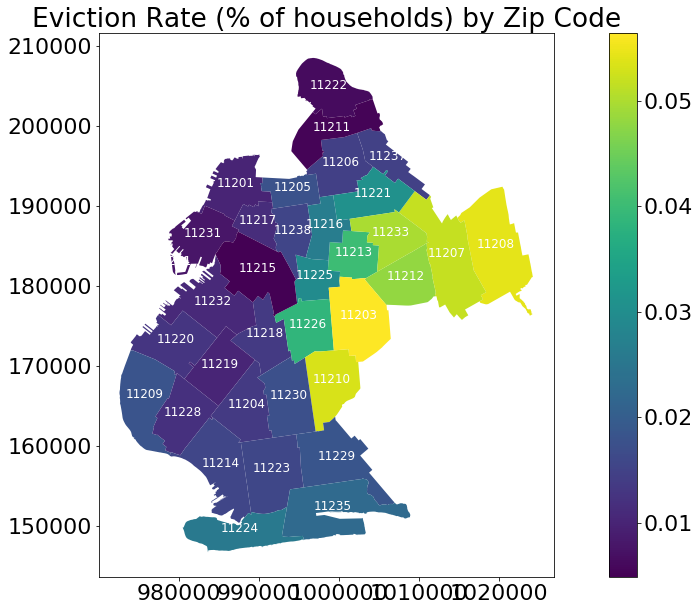

In [354]:
#View eviction-rate on map
plt.rcParams['figure.figsize'] = [20, 10]
ax=bkGeoDataZips.plot(column="EvictionRate",legend=True)
plt.title("Eviction Rate (% of households) by Zip Code")
bkGeoDataZips.apply(lambda x: ax.annotate(s=x.ZIP, xy=x.geometry.centroid.coords[0], ha='center',size=12,color='white'),axis=1);

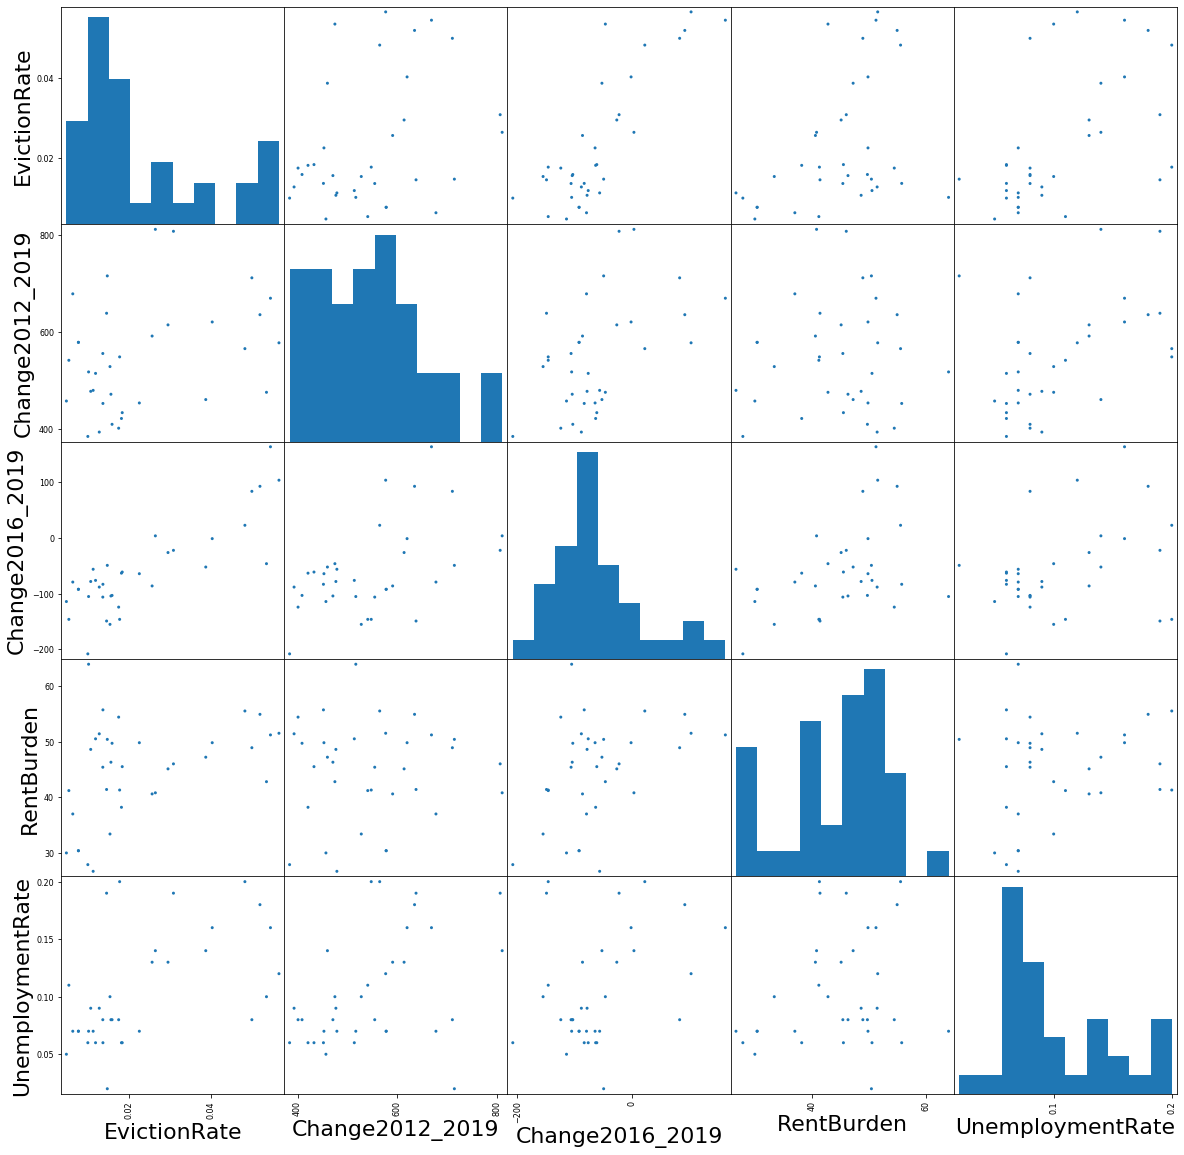

In [355]:
bkScatterZips = bkGeoDataZips[["EvictionRate", "Change2012_2019", "Change2016_2019", 
                        "RentBurden", "UnemploymentRate"]]
plt.rcParams['figure.figsize'] = [20, 20]
scatter_matrix(bkScatterZips, alpha=1)
plt.show()

<p style="color: navy; font-family: verdana; font-size: large"> In these scatter plots, there is a clear relationship with the change in rent from 2016-2019. Rent burden and unemployment rate also seem to have fairly strong correlation. As I can only use 3 independent variables on this data set, I will use those three.</p>

Result equation: 2017-2019 EvictionRate = 0.0001404620171397825(Change in Rent 2016-2019) + -1.0427751198691505e-05(Percentage rent-burdened 2018) + 0.09275510193903244(Unemployment Rate 2018) + 0.022443362033928622


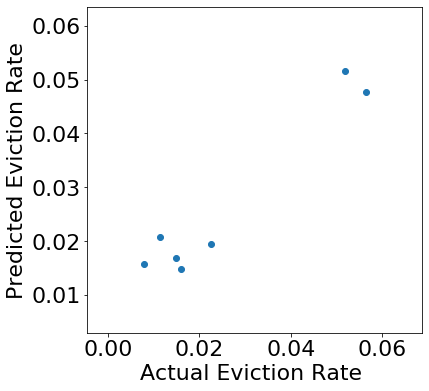

r-square: 0.760981636192497


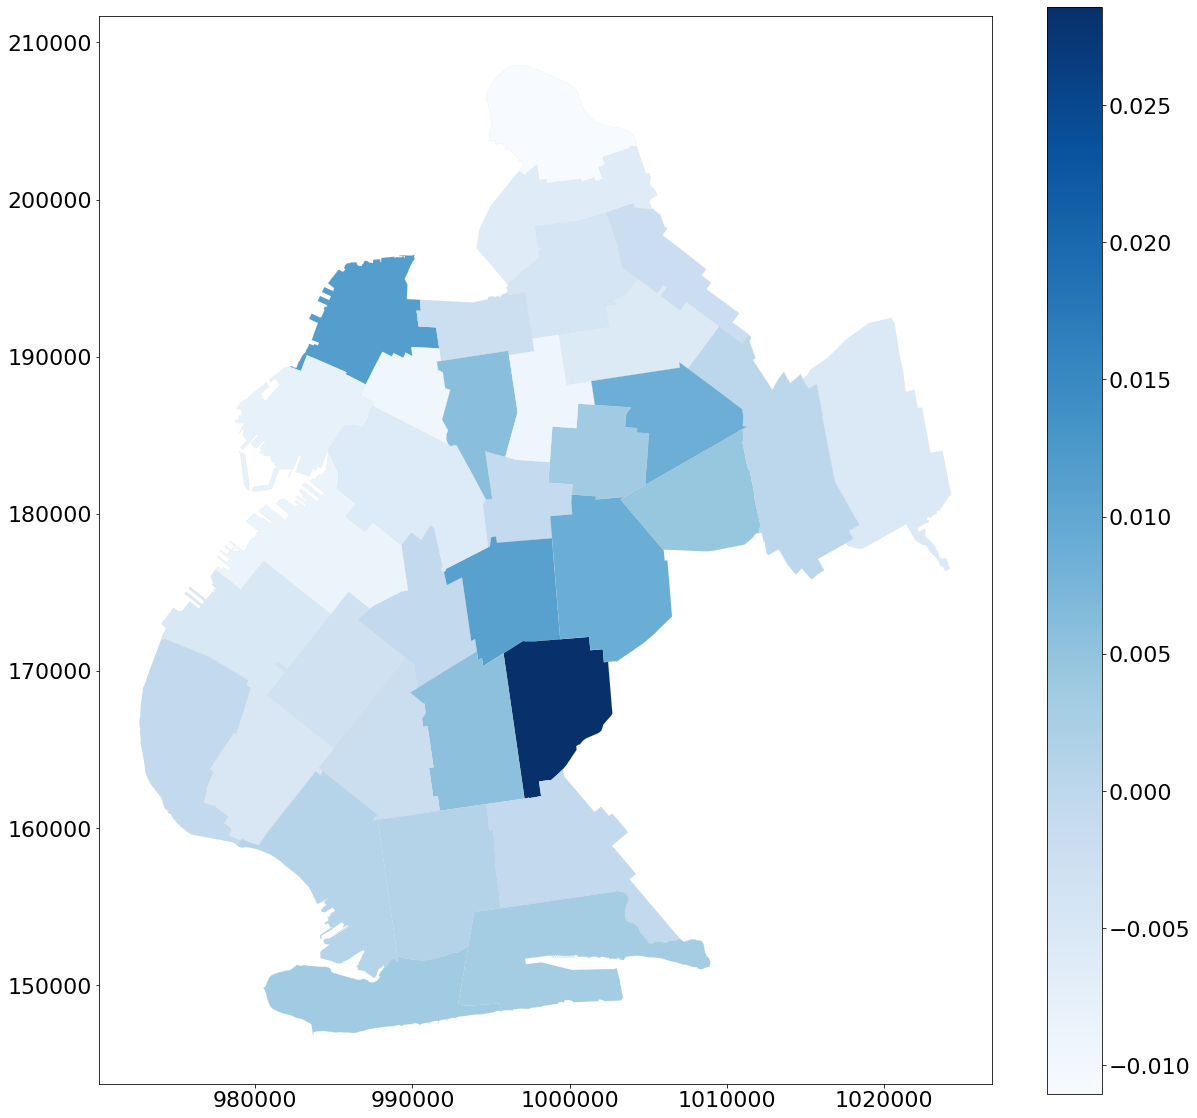

In [356]:
X = bkGeoDataZips[["Change2016_2019", 'RentBurden', "UnemploymentRate"]]
y = bkGeoDataZips["EvictionRate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
#To get the model equation
print("Result equation: 2017-2019 EvictionRate = "+ str(lm.coef_[0])+"(Change in Rent 2016-2019) + "+str(lm.coef_[1])+"(Percentage rent-burdened 2018) + "+str(lm.coef_[2])+"(Unemployment Rate 2018) + "+str(lm.intercept_))

plt.figure(figsize=(6, 6))
plt.scatter(y_test,predictions)
plt.ylabel('Predicted Eviction Rate')
plt.xlabel('Actual Eviction Rate ')
plt.show()
plt.rcParams.update({'font.size': 22})
bkGeoDataZips["predicted"] = lm.predict(X)
bkGeoDataZips["residuals"] = bkGeoDataZips["EvictionRate"] - bkGeoDataZips["predicted"] 
bkGeoDataZips.plot(column="residuals", cmap="Blues", linewidth=0.1, edgecolor="0.8", legend=True)
print('r-square: '+ str(r2_score(bkGeoDataZips["EvictionRate"], bkGeoDataZips["predicted"])))

<p style="color: navy; font-family: verdana; font-size: large"> This data has a much stronger linear relationship! The R-Squared Value is decent at .761. I had played around a little bit with changing the variables included in the model, and this came out as the best fit. Now we can move on to modeling evictions due to coronavirus unemployment.</p>
<p style="color: navy; font-family: verdana; font-size: large"> According to fivethirtyeight, each sector has so far seen these decreases in employment:</p>
<p style="color: navy; font-family: verdana; font-size: large"> -Arts/Entertainment: 48.1%</p>
<p style="color: navy; font-family: verdana; font-size: large"> -Construction: 13.2%</p>
<p style="color: navy; font-family: verdana; font-size: large"> -Trade/Transportation: 11.2%%</p>
<p style="color: navy; font-family: verdana; font-size: large"> -Education/Social Services: 10.8%</p>
<p style="color: navy; font-family: verdana; font-size: large"> -Manufacturing: 10.6%</p>
<p style="color: navy; font-family: verdana; font-size: large"> -IT: 8.9%</p>
<p style="color: navy; font-family: verdana; font-size: large"> -Finance: 3%</p>

<p style="color: navy; font-family: verdana; font-size: large"> The next step is to find the new unemployment rates by zipcode. In this dataset, we have the number of people employed in ech sector and the total number of people employed. Using the fivethirtyeight unemployment percentages, we can get an estimate of the increase in unemployment by sector by zipcode, which can then be used to find the total new unemployment per zipcode due to coronavirus.</p>

In [357]:
bkGeoDataZips['NumInArt']=bkGeoDataZips['NumInArt'].astype(float)
bkGeoDataZips['NumInConst']=bkGeoDataZips['NumInConst'].astype(float)
bkGeoDataZips['NumInTradeTransit']=bkGeoDataZips['NumInTradeTransit'].astype(float)
bkGeoDataZips['NumInSW']=bkGeoDataZips['NumInSW'].astype(float)
bkGeoDataZips['NumInManu']=bkGeoDataZips['NumInManu'].astype(float)
bkGeoDataZips['NumInIT']=bkGeoDataZips['NumInIT'].astype(float)
bkGeoDataZips['NumInFinance']=bkGeoDataZips['NumInFinance'].astype(float)

#Calculate the number of newly unemployed people
bkGeoDataZips['NumNewUnemployed'] = .48*bkGeoDataZips['NumInArt']+.132*bkGeoDataZips['NumInConst']+.112*bkGeoDataZips['NumInTradeTransit']+.108*bkGeoDataZips['NumInSW']+.106*bkGeoDataZips['NumInManu']+.089*bkGeoDataZips['NumInIT']+.03*bkGeoDataZips['NumInFinance']

#Calculate the percentage of each zipcode that is newly unemployed
bkGeoDataZips['NewUnempPct']=bkGeoDataZips['NumNewUnemployed']/bkGeoDataZips['WorkingPop']

#Add the new unemployment percentage to the previous unemployment rate to get the new unemployment rate
bkGeoDataZips['TotNewUnempPct']=bkGeoDataZips['NewUnempPct']+bkGeoDataZips['UnemploymentRate']
bkGeoDataZips.head()

,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,UnemploymentRate,EvictionsSince2017,EvictionRate,RentBurden,MedianRent2012,MedianRent2016,MedianRent2019,Change2012_2019,Change2016_2019,PctWith1.5OrMorePerRoom,WorkingPop,NumInConst,% In Construction,NumInManu,% In Manufacturing,%InTradeTransit,NumInTradeTransit,NumInIT,% In IT,NumInFinance,% In Finance,NumInSW,% In Social Work,NumInArt,% In Arts,ZIP,predicted,residuals,NumNewUnemployed,NewUnempPct,TotNewUnempPct
ZIPCODE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",0.16,850,0.040239,49.8,1703,2324,2323,620,-1,2.7,35481.5680,1590.0,0.04,1530.0,0.04,0.16,5790.0,1330.0,0.04,3420.0,0.10,11700.0,0.33,2030.0,0.06,11213,0.036624,0.003614,3479.51,0.098065,0.258065
11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",0.20,1291,0.048163,55.5,1580,2122,2145,565,23,2.3,43457.6583,2130.0,0.05,2320.0,0.05,0.16,6970.0,1010.0,0.02,3740.0,0.09,15100.0,0.35,2710.0,0.06,11212,0.043646,0.004516,4441.41,0.102201,0.302201
11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",0.13,600,0.029516,45.1,1646,2286,2260,614,-26,2.3,38812.8564,1680.0,0.04,1950.0,0.05,0.14,5620.0,1440.0,0.04,3610.0,0.09,13300.0,0.34,2440.0,0.06,11225,0.030379,-0.000863,3901.96,0.100533,0.230533
11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",0.08,216,0.013706,45.4,1630,2291,2185,555,-106,5.4,42162.6761,2640.0,0.06,3080.0,0.07,0.17,7330.0,1510.0,0.04,4630.0,0.11,10100.0,0.24,3540.0,0.08,11218,0.014501,-0.000796,4559.21,0.108134,0.188134
11226,0,Brooklyn,106132.0,3.940860e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((994821.473 177865.718, 994891.817 17...",0.14,1244,0.038671,47.2,1656,2168,2116,460,-52,6.1,65167.9406,3250.0,0.05,3790.0,0.06,0.17,11100.0,2290.0,0.04,5620.0,0.09,21100.0,0.32,4270.0,0.07,11226,0.027633,0.011038,6774.75,0.103958,0.243958


<p style="color: navy; font-family: verdana; font-size: large"> Using the model equation: 2017-2019 EvictionRate = 0.0001404620171397825(Change in Rent 2016-2019) + -1.0427751198691505e-05(Percentage rent-burdened 2018) + 0.09275510193903244(Unemployment Rate 2018) + 0.022443362033928622, we can now create a column of predicted evictions based on the new unemployment rate. </p>

In [358]:
bkGeoDataZips['NewEvictionRate']=0.0001404620171397825*bkGeoDataZips['Change2016_2019'] + -1.0427751198691505e-05*bkGeoDataZips['RentBurden'] + 0.09275510193903244*bkGeoDataZips['TotNewUnempPct'] + 0.022443362033928622
bkGeoDataZips['ChangeEvicRate']=bkGeoDataZips['NewEvictionRate']-bkGeoDataZips['EvictionRate']
bkGeoDataZips['NumNewEvictions']=bkGeoDataZips['ChangeEvicRate']*bkGeoDataZips['EvictionsSince2017']

#If the number of new evictions predicted is <0, set it to 0.
bkGeoDataZips.loc[bkGeoDataZips['NumNewEvictions'] < 0, 'NumNewEvictions'] = 0
    
bkGeoDataZips.head()

,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,UnemploymentRate,EvictionsSince2017,EvictionRate,RentBurden,MedianRent2012,MedianRent2016,MedianRent2019,Change2012_2019,Change2016_2019,PctWith1.5OrMorePerRoom,WorkingPop,NumInConst,% In Construction,NumInManu,% In Manufacturing,%InTradeTransit,NumInTradeTransit,NumInIT,% In IT,NumInFinance,% In Finance,NumInSW,% In Social Work,NumInArt,% In Arts,ZIP,predicted,residuals,NumNewUnemployed,NewUnempPct,TotNewUnempPct,NewEvictionRate,ChangeEvicRate,NumNewEvictions
ZIPCODE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",0.16,850,0.040239,49.8,1703,2324,2323,620,-1,2.7,35481.5680,1590.0,0.04,1530.0,0.04,0.16,5790.0,1330.0,0.04,3420.0,0.10,11700.0,0.33,2030.0,0.06,11213,0.036624,0.003614,3479.51,0.098065,0.258065,0.045720,0.005482,4.659597
11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",0.20,1291,0.048163,55.5,1580,2122,2145,565,23,2.3,43457.6583,2130.0,0.05,2320.0,0.05,0.16,6970.0,1010.0,0.02,3740.0,0.09,15100.0,0.35,2710.0,0.06,11212,0.043646,0.004516,4441.41,0.102201,0.302201,0.053126,0.004963,6.407573
11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",0.13,600,0.029516,45.1,1646,2286,2260,614,-26,2.3,38812.8564,1680.0,0.04,1950.0,0.05,0.14,5620.0,1440.0,0.04,3610.0,0.09,13300.0,0.34,2440.0,0.06,11225,0.030379,-0.000863,3901.96,0.100533,0.230533,0.039704,0.010188,6.112920
11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",0.08,216,0.013706,45.4,1630,2291,2185,555,-106,5.4,42162.6761,2640.0,0.06,3080.0,0.07,0.17,7330.0,1510.0,0.04,4630.0,0.11,10100.0,0.24,3540.0,0.08,11218,0.014501,-0.000796,4559.21,0.108134,0.188134,0.024531,0.010826,2.338363
11226,0,Brooklyn,106132.0,3.940860e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((994821.473 177865.718, 994891.817 17...",0.14,1244,0.038671,47.2,1656,2168,2116,460,-52,6.1,65167.9406,3250.0,0.05,3790.0,0.06,0.17,11100.0,2290.0,0.04,5620.0,0.09,21100.0,0.32,4270.0,0.07,11226,0.027633,0.011038,6774.75,0.103958,0.243958,0.037276,-0.001395,0.000000


<p style="color: navy; font-family: verdana; font-size: large"> Finally we have the number of new evictions predicted by zip code! In total, Brooklyn may see 123 new evictions due to unemployment caused by coronavirus. We can now map it by zipcode. </p>

Total new evictions predicted directly due to unemployment caused by coronavirus: 123.08685886765993


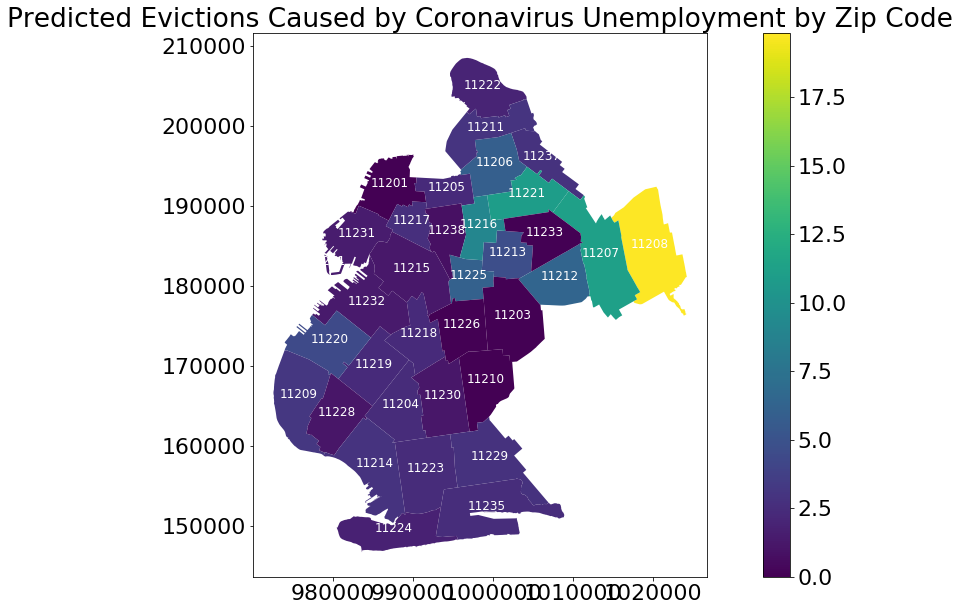

In [359]:
Total = bkGeoDataZips['NumNewEvictions'].sum()
print("Total new evictions predicted directly due to unemployment caused by coronavirus: " + str(Total))
#View new evictions on map
plt.rcParams['figure.figsize'] = [20, 10]
ax=bkGeoDataZips.plot(column="NumNewEvictions", legend=True)
plt.title("Predicted Evictions Caused by Coronavirus Unemployment by Zip Code")
bkGeoDataZips.apply(lambda x: ax.annotate(s=x.ZIP, xy=x.geometry.centroid.coords[0], ha='center',size=12,color='white'),axis=1);